# Fault detection for INS of a ship described by Nomoto second order model

INS (Inertial navigation system) includes a gyriscope and accelerometer

## Data import and analysis

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [45]:
files = glob.glob('datasets/*.csv')

measurement_step = 100

data = []
for file in files:
  if(file != 'data_model.csv'):
      temp = pd.read_csv(file, usecols = ['u1', 'y1', 'y2', 'y_nominal1', 'y_nominal2', 'fault_u1',
       'fault_y1', 'fault_y2', 'comp_fault'])
      indexes = range(0, temp.shape[0], measurement_step)
      temp = temp.iloc[indexes][:]
      data.append(temp)      
len(data)

280

In [46]:
data[0].shape

(50, 9)

In [47]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 4900
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   u1          50 non-null     float64
 1   y1          50 non-null     float64
 2   y2          50 non-null     float64
 3   y_nominal1  50 non-null     float64
 4   y_nominal2  50 non-null     float64
 5   fault_u1    50 non-null     float64
 6   fault_y1    50 non-null     float64
 7   fault_y2    50 non-null     float64
 8   comp_fault  50 non-null     float64
dtypes: float64(9)
memory usage: 3.9 KB


In [48]:
data[10].tail()

,u1,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_y1,fault_y2,comp_fault
4500,-0.221198,-0.210813,0.165109,-0.251443,0.107338,0.0,0.0,0.0,0.0
4600,0.133344,-0.187746,0.585067,-0.199047,0.314831,0.0,0.0,0.0,0.0
4700,-0.014817,0.322831,-0.174711,0.346907,-0.258333,0.0,0.0,0.0,0.0
4800,-0.107118,0.045924,-0.181092,0.032668,-0.190933,0.0,0.0,0.0,0.0
4900,0.204413,-0.383175,0.228794,-0.362575,0.349905,0.0,0.0,0.0,0.0


Check fault cases

In [49]:
u1 = []
y1 = []
y2 = []
comp = []
for s in range(len(data)):
  df = data[s].loc[data[s]['fault_u1'] != 0]
  if (df.empty != True):
    u1.append(s)
  df = data[s].loc[data[s]['fault_y1'] != 0]
  if (df.empty != True):
    y1.append(s)
  df = data[s].loc[data[s]['fault_y2'] != 0]
  if (df.empty != True):
    y2.append(s)
  df = data[s].loc[(data[s]['fault_y2'] != 0) & (data[s]['fault_y1'] != 0)]
  if (df.empty != True):
    comp.append(s)

print('y1 faults in samples ', y1)
print('y2 faults in samples ', y2)

y1 faults in samples  [25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259]
y2 faults in samples  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 19

## Feature engineering

Add features:
- previous values for each measurement (parameter max_lag)
- rolling mean value (parameters rolling_mean_first_size and count_rolling)
- first derivative
- second derivative

In [50]:
def make_features(df, max_lag, rolling_mean_first_size, count_rolling):
    df_res = df.copy()
    # Add n lags
    for lag in range(1, max_lag + 1):
        df_res['y1_lag_{}'.format(lag)] = df_res['y1'].shift(lag)
        df_res['y2_lag_{}'.format(lag)] = df_res['y2'].shift(lag)
        df_res['y_nominal1_lag_{}'.format(lag)] = df_res['y_nominal1'].shift(lag)
        df_res['y_nominal2_lag_{}'.format(lag)] = df_res['y_nominal2'].shift(lag)
# Add rolling mean
    df_cols = ['y1',	'y2',	'y_nominal1',	'y_nominal2']
    for counts in range(1, (count_rolling + 1)):
      for rol in range(len(df_cols)):
        s = df_cols[rol]+'_rolling_mean_{}'.format(rolling_mean_first_size*counts)
        df_res[s] = df_res[df_cols[rol]].shift().rolling(rolling_mean_first_size*counts).mean()
        # Add first derivative
    if (max_lag > 0):
      df_res['Vy1'] = df_res['y1'] - df_res['y1_lag_1']
      df_res['Vy2'] = df_res['y2'] - df_res['y2_lag_1']
      df_res['Vy_nominal1'] = df_res['y_nominal1'] - df_res['y_nominal1_lag_1']
      df_res['Vy_nominal2'] = df_res['y_nominal2'] - df_res['y_nominal2_lag_1']
    if (max_lag > 1): # Add second derivative
      df_res['Ay1'] = df_res['Vy1'] - (df_res['y1_lag_1'] - df_res['y1_lag_2'])
      df_res['Ay2'] = df_res['Vy2'] - (df_res['y2_lag_1'] - df_res['y2_lag_2'])
      df_res['Ay_nominal1'] = df_res['Vy_nominal1'] - (df_res['y_nominal1_lag_1'] - df_res['y_nominal1_lag_2'])
      df_res['Ay_nominal2'] = df_res['Vy_nominal2'] - (df_res['y_nominal2_lag_1'] - df_res['y_nominal2_lag_2'])
    if (max_lag > 2): # Add third derivative
      df_res['jy1'] = df_res['Ay1'] - (df_res['y1_lag_1'] - 2*df_res['y1_lag_2'] + df_res['y1_lag_3'])
      df_res['jy2'] = df_res['Ay2'] - (df_res['y2_lag_1'] - 2*df_res['y2_lag_2'] + df_res['y2_lag_3'])
      df_res['jy_nominal1'] = df_res['Ay_nominal1'] - (df_res['y_nominal1_lag_1'] - 2*df_res['y_nominal1_lag_2'] + df_res['y_nominal1_lag_3'])
      df_res['jy_nominal2'] = df_res['Ay_nominal2'] - (df_res['y_nominal2_lag_1'] - 2*df_res['y_nominal2_lag_2'] + df_res['y_nominal2_lag_3'])

    df_res = df_res.dropna().reset_index(drop=True)
    return df_res

In [51]:
augmented_data = []
for df1 in data:
  df1 = df1.drop(['fault_u1', 'comp_fault'], axis=1)
  augmented_data.append(make_features(df1, 2, 5, 2))

In [52]:
len(augmented_data)

280

In [53]:
for df1 in augmented_data:
    df1['fault_y1'] = df1['fault_y1'].astype(np.int8)
    df1['fault_y2'] = df1['fault_y2'].astype(np.int8)

augmented_data[3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   u1                          40 non-null     float64
 1   y1                          40 non-null     float64
 2   y2                          40 non-null     float64
 3   y_nominal1                  40 non-null     float64
 4   y_nominal2                  40 non-null     float64
 5   fault_y1                    40 non-null     int8   
 6   fault_y2                    40 non-null     int8   
 7   y1_lag_1                    40 non-null     float64
 8   y2_lag_1                    40 non-null     float64
 9   y_nominal1_lag_1            40 non-null     float64
 10  y_nominal2_lag_1            40 non-null     float64
 11  y1_lag_2                    40 non-null     float64
 12  y2_lag_2                    40 non-null     float64
 13  y_nominal1_lag_2            40 non-nu

In [54]:
augmented_data[5].head()

,u1,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2,y1_lag_1,y2_lag_1,y_nominal1_lag_1,...,y_nominal1_rolling_mean_10,y_nominal2_rolling_mean_10,Vy1,Vy2,Vy_nominal1,Vy_nominal2,Ay1,Ay2,Ay_nominal1,Ay_nominal2
0,-0.073428,0.105847,0.012385,0.146901,0.158164,0,0,-0.001258,0.083172,0.011643,...,0.134420,-0.024413,0.107104,-0.070787,0.135258,0.125704,0.023451,-0.152879,-0.008436,-0.023655
1,-0.012372,0.098878,0.089909,0.175122,0.168609,0,0,0.105847,0.012385,0.146901,...,0.066189,0.009427,-0.006969,0.077524,0.028221,0.010446,-0.114073,0.148311,-0.107037,-0.115258
2,0.078177,0.152718,0.099235,0.075730,0.056184,0,0,0.098878,0.089909,0.175122,...,0.052430,0.036398,0.053840,0.009326,-0.099392,-0.112425,0.060808,-0.068198,-0.127613,-0.122871
3,-0.017638,-0.048143,-0.046339,-0.078847,-0.097184,0,0,0.152718,0.099235,0.075730,...,0.043781,0.036844,-0.200861,-0.145573,-0.154577,-0.153368,-0.254701,-0.154899,-0.055186,-0.040943
4,-0.071406,-0.240253,-0.185839,-0.175966,-0.179731,0,0,-0.048143,-0.046339,-0.078847,...,0.016382,0.010441,-0.192109,-0.139500,-0.097119,-0.082547,0.008752,0.006074,0.057459,0.070821


In [55]:
all_data = pd.DataFrame()
for df in augmented_data:
  all_data = pd.concat([all_data, df], ignore_index = True)

In [56]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   u1                          11200 non-null  float64
 1   y1                          11200 non-null  float64
 2   y2                          11200 non-null  float64
 3   y_nominal1                  11200 non-null  float64
 4   y_nominal2                  11200 non-null  float64
 5   fault_y1                    11200 non-null  int8   
 6   fault_y2                    11200 non-null  int8   
 7   y1_lag_1                    11200 non-null  float64
 8   y2_lag_1                    11200 non-null  float64
 9   y_nominal1_lag_1            11200 non-null  float64
 10  y_nominal2_lag_1            11200 non-null  float64
 11  y1_lag_2                    11200 non-null  float64
 12  y2_lag_2                    11200 non-null  float64
 13  y_nominal1_lag_2            112

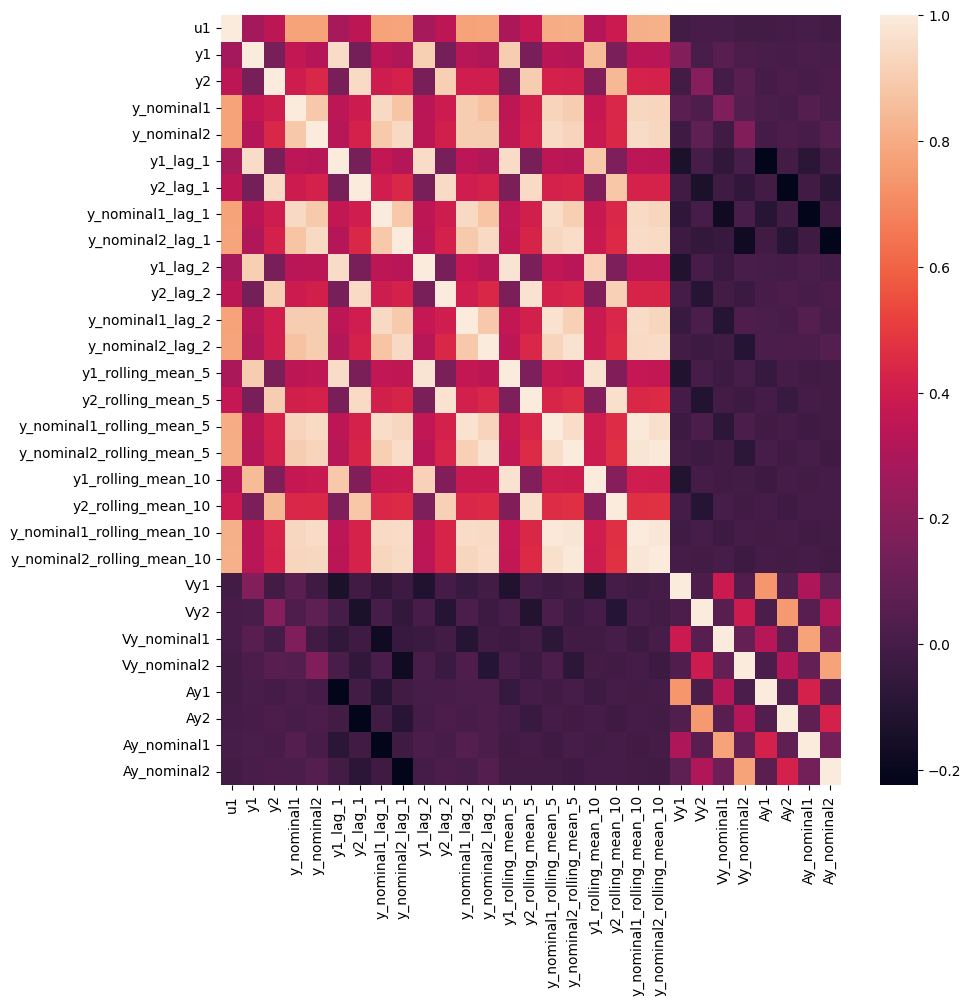

In [57]:
def _heatmap(df):
  df_features = df.drop(['fault_y1', 'fault_y2'], axis = 1)
  cor = df_features.corr()
  plt.figure(figsize = (10, 10))
  sns.heatmap(cor)
  plt.show
  del df_features
  
_heatmap(all_data)

In [58]:
all_data.describe()

,u1,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2,y1_lag_1,y2_lag_1,y_nominal1_lag_1,...,y_nominal1_rolling_mean_10,y_nominal2_rolling_mean_10,Vy1,Vy2,Vy_nominal1,Vy_nominal2,Ay1,Ay2,Ay_nominal1,Ay_nominal2
count,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,...,11200.000000,11200.000000,11200.000000,11200.000000,1.120000e+04,1.120000e+04,11200.000000,11200.000000,11200.000000,1.120000e+04
mean,-0.028475,0.022856,-0.130287,-0.084243,-0.084090,0.398036,0.361071,0.024257,-0.129914,-0.084018,...,-0.084251,-0.083814,-0.001401,-0.000373,-2.247097e-04,-2.617901e-05,-0.001784,0.001071,-0.000514,1.062971e-04
std,0.243335,1.597009,1.670187,0.626377,0.626163,0.873842,0.841901,1.584831,1.655662,0.626477,...,0.592302,0.595454,0.504388,0.541272,2.169066e-01,2.169281e-01,0.726994,0.805013,0.336246,3.359682e-01
min,-0.497757,-7.880744,-9.678349,-1.444806,-1.444806,0.000000,0.000000,-7.880744,-9.678349,-1.444806,...,-1.444806,-1.444806,-9.848734,-9.985708,-1.018831e+00,-1.017725e+00,-9.850683,-9.985708,-1.655907,-1.656808e+00
25%,-0.209246,-0.452468,-0.505974,-0.407136,-0.407136,0.000000,0.000000,-0.451242,-0.504040,-0.407136,...,-0.326837,-0.326837,-0.064179,-0.122567,-1.538826e-04,-5.829303e-04,-0.111263,-0.201267,-0.000886,-4.395373e-13
50%,-0.019545,-0.025425,-0.047165,-0.021658,-0.022765,0.000000,0.000000,-0.024380,-0.047560,-0.021658,...,-0.002112,-0.001914,0.000000,0.000000,1.665779e-12,4.440892e-16,0.000000,0.000000,0.000000,0.000000e+00
75%,0.151155,0.282306,0.273972,0.185532,0.180075,0.000000,0.000000,0.282306,0.271045,0.186285,...,0.022637,0.020480,0.065318,0.119681,2.141341e-05,4.959921e-13,0.110493,0.201583,0.000030,1.527948e-04
max,0.496916,8.728162,9.327207,1.429651,1.429651,3.000000,3.000000,8.728162,9.327207,1.429651,...,1.429651,1.429651,9.850683,9.858131,1.021889e+00,1.022025e+00,9.891249,10.297648,1.656833,1.655833e+00


## Dataset preparation

In [59]:
augmented_data[0].shape

(40, 31)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_data.drop(['fault_y1', 'fault_y2'], axis=1))
scaler.feature_names_in_

array(['u1', 'y1', 'y2', 'y_nominal1', 'y_nominal2', 'y1_lag_1',
       'y2_lag_1', 'y_nominal1_lag_1', 'y_nominal2_lag_1', 'y1_lag_2',
       'y2_lag_2', 'y_nominal1_lag_2', 'y_nominal2_lag_2',
       'y1_rolling_mean_5', 'y2_rolling_mean_5',
       'y_nominal1_rolling_mean_5', 'y_nominal2_rolling_mean_5',
       'y1_rolling_mean_10', 'y2_rolling_mean_10',
       'y_nominal1_rolling_mean_10', 'y_nominal2_rolling_mean_10', 'Vy1',
       'Vy2', 'Vy_nominal1', 'Vy_nominal2', 'Ay1', 'Ay2', 'Ay_nominal1',
       'Ay_nominal2'], dtype=object)

Prepare sliding window of data with length 'lag'. Fault occured if fault signal exist larger than half of window.

In [62]:
import numpy as np

X, y = [], []

lag = 10
k, total = 0, len(augmented_data)
for single_data in augmented_data:
    for i in range(lag, single_data.shape[0]):
        df = single_data.loc[(i-lag):i, :]
        sample_X = df.drop(['fault_y1', 'fault_y2'], axis=1)
        sample_X = scaler.transform(sample_X)
        sample_y = np.array(df[['fault_y1', 'fault_y2']])
        sample_y = np.array([(np.sum(sample_y[:, 0])>10) *1, 
                             (np.sum(sample_y[:, 1])>10) *1
                             ], dtype=np.int8)
        X.append(np.array(sample_X))
        y.append(np.array(sample_y))
    k += 1

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(8400, 11, 29) (8400, 2)


In [63]:
counts = [0, 0, 0, 0]
for result in y:
    if np.array_equal(result, [0, 0]):
        counts[0] += 1
    elif np.array_equal(result, [0, 1]):
        counts[1] += 1
    elif np.array_equal(result, [1, 0]):
        counts[2] += 1
    else:
        counts[3] += 1
counts

[5156, 1506, 1738, 0]

In [64]:
X.tofile('X_data.csv', sep=',')
y.tofile('y_data.csv', sep=',')

In [3]:
X = np.fromfile('X_data.csv', dtype=float, sep=',')
y = np.fromfile('y_data.csv', dtype=np.int8, sep=',')
X = X.reshape((8400, 11, 29))
y = y.reshape((8400, 2))
X.shape, y.shape

((8400, 11, 29), (8400, 2))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Linear models
### Ridge

In [5]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def reshape_X_3d_to_2d(data):
    samples, steps, n_features = data.shape
    return data.reshape(samples, steps * n_features)

X_train2d, X_test2d = reshape_X_3d_to_2d(X_train), reshape_X_3d_to_2d(X_test)
X_train2d.shape, X_test2d.shape

((6300, 319), (2100, 319))

In [6]:
def reshape_y_2d_to_1d(data):
    data_new = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        if np.array_equal(data[i], [0, 0]):
            data_new[i] = 0
        elif np.array_equal(data[i], [0, 1]):
            data_new[i] = 1
        elif np.array_equal(data[i], [1, 0]):
            data_new[i] = 2
        else:
            data_new[i] = -1
    return data_new

y_train1d, y_test_1d = reshape_y_2d_to_1d(y_train), reshape_y_2d_to_1d(y_test)
print(np.unique(y_train1d, return_counts=True))
print(y_train1d.shape, y_test_1d.shape)

(array([0., 1., 2.]), array([3877, 1104, 1319], dtype=int64))
(6300,) (2100,)


In [69]:
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train2d, y_train1d) 

RidgeClassifier()

In [70]:
predictions = ridge_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

array([[3873,    3,    1],
       [1087,   17,    0],
       [1144,    0,  175]], dtype=int64)

In [71]:
from sklearn.linear_model import RidgeClassifierCV

ridge_clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train2d, y_train1d) 
predictions = ridge_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

array([[3873,    3,    1],
       [1087,   17,    0],
       [1144,    0,  175]], dtype=int64)

### Lasso

In [72]:
from sklearn.linear_model import LogisticRegressionCV

lasso_clf = LogisticRegressionCV(penalty='l1', Cs=[1e-3, 1e-2, 1e-1, 1], solver='saga')
lasso_clf.fit(X_train2d, y_train1d) 
predictions = lasso_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\p

array([[3877,    0,    0],
       [1091,   13,    0],
       [1126,    0,  193]], dtype=int64)

## Elastic net

In [73]:
from sklearn.linear_model import LogisticRegressionCV

elnet_clf = LogisticRegressionCV(penalty='elasticnet', Cs=[1e-3, 1e-2, 1e-1, 1],
                                 l1_ratios=[1e-3, 1e-2, 1e-1, 1], solver='saga')
elnet_clf.fit(X_train2d, y_train1d) 
predictions = elnet_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\p

array([[3876,    1,    0],
       [1084,   20,    0],
       [1130,    0,  189]], dtype=int64)

### SVM

In [79]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty':('l1', 'l2'), 'C':(0.001, 0.01, 0.1, 1, 10, 100), 'dual':('auto',)}
svm_lin_clf = GridSearchCV(LinearSVC(), param_grid, refit=True, verbose=2)

svm_lin_clf.fit(X_train2d, y_train1d)
predictions = svm_lin_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.001, dual=auto, penalty=l1; total time=   0.0s
[CV] END .....................C=0.001, dual=auto, penalty=l1; total time=   0.0s
[CV] END .....................C=0.001, dual=auto, penalty=l1; total time=   0.0s
[CV] END .....................C=0.001, dual=auto, penalty=l1; total time=   0.0s
[CV] END .....................C=0.001, dual=auto, penalty=l1; total time=   0.0s
[CV] END .....................C=0.001, dual=auto, penalty=l2; total time=   0.6s
[CV] END .....................C=0.001, dual=auto, penalty=l2; total time=   0.5s
[CV] END .....................C=0.001, dual=auto, penalty=l2; total time=   0.5s
[CV] END .....................C=0.001, dual=auto, penalty=l2; total time=   0.6s
[CV] END .....................C=0.001, dual=auto, penalty=l2; total time=   0.6s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ......................C=0.01, dual=auto, penalty=l1; total time=   0.5s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ......................C=0.01, dual=auto, penalty=l1; total time=   0.4s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ......................C=0.01, dual=auto, penalty=l1; total time=   0.5s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ......................C=0.01, dual=auto, penalty=l1; total time=   0.5s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ......................C=0.01, dual=auto, penalty=l1; total time=   0.5s
[CV] END ......................C=0.01, dual=auto, penalty=l2; total time=   1.2s
[CV] END ......................C=0.01, dual=auto, penalty=l2; total time=   1.3s
[CV] END ......................C=0.01, dual=auto, penalty=l2; total time=   1.1s
[CV] END ......................C=0.01, dual=auto, penalty=l2; total time=   1.3s
[CV] END ......................C=0.01, dual=auto, penalty=l2; total time=   1.2s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=0.1, dual=auto, penalty=l1; total time=   1.5s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=0.1, dual=auto, penalty=l1; total time=   1.6s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=0.1, dual=auto, penalty=l1; total time=   1.6s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=0.1, dual=auto, penalty=l1; total time=   1.6s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=0.1, dual=auto, penalty=l1; total time=   1.6s
[CV] END .......................C=0.1, dual=auto, penalty=l2; total time=   2.8s
[CV] END .......................C=0.1, dual=auto, penalty=l2; total time=   2.5s
[CV] END .......................C=0.1, dual=auto, penalty=l2; total time=   2.7s
[CV] END .......................C=0.1, dual=auto, penalty=l2; total time=   2.4s
[CV] END .......................C=0.1, dual=auto, penalty=l2; total time=   2.6s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........................C=1, dual=auto, penalty=l1; total time=   3.1s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........................C=1, dual=auto, penalty=l1; total time=   2.9s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........................C=1, dual=auto, penalty=l1; total time=   3.1s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........................C=1, dual=auto, penalty=l1; total time=   2.8s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........................C=1, dual=auto, penalty=l1; total time=   3.0s
[CV] END .........................C=1, dual=auto, penalty=l2; total time=   4.7s
[CV] END .........................C=1, dual=auto, penalty=l2; total time=   4.0s
[CV] END .........................C=1, dual=auto, penalty=l2; total time=   4.3s
[CV] END .........................C=1, dual=auto, penalty=l2; total time=   4.5s
[CV] END .........................C=1, dual=auto, penalty=l2; total time=   4.3s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........................C=10, dual=auto, penalty=l1; total time=   6.2s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........................C=10, dual=auto, penalty=l1; total time=   5.9s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........................C=10, dual=auto, penalty=l1; total time=   6.7s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........................C=10, dual=auto, penalty=l1; total time=   6.1s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........................C=10, dual=auto, penalty=l1; total time=   6.0s
[CV] END ........................C=10, dual=auto, penalty=l2; total time=   7.0s
[CV] END ........................C=10, dual=auto, penalty=l2; total time=   6.1s
[CV] END ........................C=10, dual=auto, penalty=l2; total time=   5.8s
[CV] END ........................C=10, dual=auto, penalty=l2; total time=   5.5s
[CV] END ........................C=10, dual=auto, penalty=l2; total time=   7.4s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=100, dual=auto, penalty=l1; total time=   9.1s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=100, dual=auto, penalty=l1; total time=   9.1s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=100, dual=auto, penalty=l1; total time=   9.3s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=100, dual=auto, penalty=l1; total time=   9.0s


c:\python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......................C=100, dual=auto, penalty=l1; total time=   9.0s
[CV] END .......................C=100, dual=auto, penalty=l2; total time=   7.3s
[CV] END .......................C=100, dual=auto, penalty=l2; total time=   6.9s
[CV] END .......................C=100, dual=auto, penalty=l2; total time=   6.5s
[CV] END .......................C=100, dual=auto, penalty=l2; total time=   6.6s
[CV] END .......................C=100, dual=auto, penalty=l2; total time=   7.7s


array([[3877,    0,    0],
       [1096,    8,    0],
       [1135,    0,  184]], dtype=int64)

In [80]:
from sklearn.svm import SVC

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}

svm_clf = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

svm_clf.fit(X_train2d, y_train1d) 
predictions = svm_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.9s
[CV] END .......................C=0.1, gamma=0.

array([[3873,    0,    4],
       [ 126,  978,    0],
       [ 239,    0, 1080]], dtype=int64)

In [81]:
svm_clf.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [82]:
predictions = svm_clf.predict(X_test2d)
confusion_matrix(y_test_1d, predictions)

array([[1211,   19,   49],
       [ 120,  274,    8],
       [ 127,    3,  289]], dtype=int64)

### Gradient boosted trees

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': (0.01, 0.1, 1),}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, refit=True, verbose=2)
gbm_clf.fit(X_train2d, y_train1d)
gbm_clf.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .................................learning_rate=0.01; total time= 4.2min
[CV] END .................................learning_rate=0.01; total time= 4.0min
[CV] END .................................learning_rate=0.01; total time= 4.1min
[CV] END .................................learning_rate=0.01; total time= 4.0min
[CV] END .................................learning_rate=0.01; total time= 4.0min
[CV] END ..................................learning_rate=0.1; total time= 4.0min
[CV] END ..................................learning_rate=0.1; total time= 4.0min
[CV] END ..................................learning_rate=0.1; total time= 4.0min
[CV] END ..................................learning_rate=0.1; total time= 4.0min
[CV] END ..................................learning_rate=0.1; total time= 4.0min
[CV] END ....................................learning_rate=1; total time= 4.0min
[CV] END ....................................lear

{'learning_rate': 1}

In [10]:
param_grid = {'learning_rate': (0.3, 0.4, 0.5, 0.6, 0.7),}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, refit=True, verbose=2)
gbm_clf.fit(X_train2d, y_train1d)
gbm_clf.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..................................learning_rate=0.3; total time= 4.3min
[CV] END ..................................learning_rate=0.3; total time= 4.0min
[CV] END ..................................learning_rate=0.3; total time= 4.0min
[CV] END ..................................learning_rate=0.3; total time= 4.0min
[CV] END ..................................learning_rate=0.3; total time= 4.0min
[CV] END ..................................learning_rate=0.4; total time= 4.0min
[CV] END ..................................learning_rate=0.4; total time= 4.0min
[CV] END ..................................learning_rate=0.4; total time= 4.0min
[CV] END ..................................learning_rate=0.4; total time= 4.0min
[CV] END ..................................learning_rate=0.4; total time= 4.0min
[CV] END ..................................learning_rate=0.5; total time= 4.0min
[CV] END ..................................learni

{'learning_rate': 0.4}

In [12]:
param_grid = {'learning_rate': (0.4,), 'min_samples_split': (2, 4)}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, verbose=2)
gbm_clf.fit(X_train2d, y_train1d)
gbm_clf.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .............learning_rate=0.4, min_samples_split=2; total time= 4.2min
[CV] END .............learning_rate=0.4, min_samples_split=2; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=2; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=2; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=2; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=4; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=4; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=4; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=4; total time= 4.0min
[CV] END .............learning_rate=0.4, min_samples_split=4; total time= 4.0min


{'learning_rate': 0.4, 'min_samples_split': 2}

In [15]:
param_grid = {'learning_rate': (0.4,), 'min_samples_split': (2,), 'min_samples_leaf':(1, 2, 4)}
gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, verbose=2)
gbm_clf.fit(X_train2d, y_train1d)
gbm_clf.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END learning_rate=0.4, min_samples_leaf=1, min_samples_split=2; total time= 4.3min
[CV] END learning_rate=0.4, min_samples_leaf=1, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=1, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=1, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=1, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=2, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=2, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=2, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=2, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=2, min_samples_split=2; total time= 4.0min
[CV] END learning_rate=0.4, min_samples_leaf=4, min_samples_

{'learning_rate': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [17]:
param_grid = {'learning_rate': (0.4,), 'n_estimators':(10, 50, 100, 200, 300, 400),
              'min_samples_split': (2,), 'min_samples_leaf':(1,),
              'max_depth':(2, 4)}

gbm_clf = GridSearchCV(GradientBoostingClassifier(), param_grid, refit=True, cv=5, verbose=2)
gbm_clf.fit(X_train2d, y_train1d)
predictions = gbm_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  19.2s
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  19.2s
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  19.3s
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  19.3s
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=  19.1s
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END learning_rate=0.4, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.

array([[3877,    0,    0],
       [   0, 1104,    0],
       [   0,    0, 1319]], dtype=int64)

In [18]:
gbm_clf.best_params_

{'learning_rate': 0.4,
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

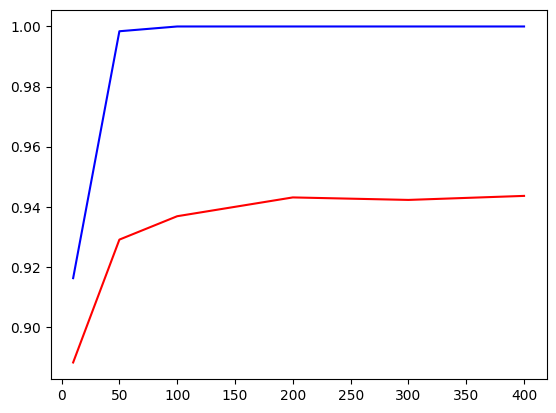

In [24]:
from sklearn.metrics import f1_score

n_estimators_values = (10, 50, 100, 200, 300, 400)

train_score, test_score = [], []
for n_estimators in n_estimators_values:
    gbm_clf = GradientBoostingClassifier(learning_rate=0.4, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=n_estimators)
    gbm_clf.fit(X_train2d, y_train1d)
    predictions = gbm_clf.predict(X_train2d)
    train_f1 = f1_score(y_train1d, predictions, average='weighted')
    train_score.append(train_f1)
    predictions = gbm_clf.predict(X_test2d)
    test_f1 = f1_score(y_test_1d, predictions, average='weighted')
    test_score.append(test_f1)
plt.plot(n_estimators_values, train_score, c='b')
plt.plot(n_estimators_values, test_score, c='r')

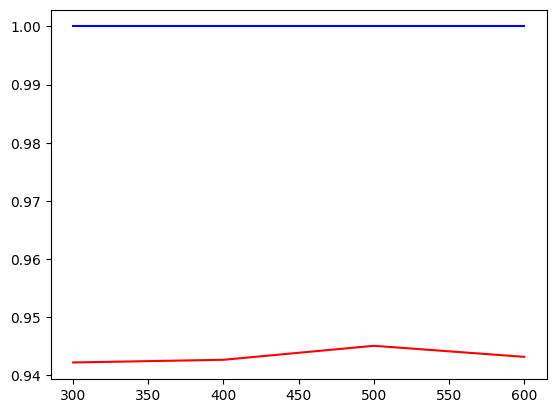

In [25]:
n_estimators_values = (300, 400, 500, 600)

train_score, test_score = [], []
for n_estimators in n_estimators_values:
    gbm_clf = GradientBoostingClassifier(learning_rate=0.4, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=n_estimators)
    gbm_clf.fit(X_train2d, y_train1d)
    predictions = gbm_clf.predict(X_train2d)
    train_f1 = f1_score(y_train1d, predictions, average='weighted')
    train_score.append(train_f1)
    predictions = gbm_clf.predict(X_test2d)
    test_f1 = f1_score(y_test_1d, predictions, average='weighted')
    test_score.append(test_f1)
plt.plot(n_estimators_values, train_score, c='b')
plt.plot(n_estimators_values, test_score, c='r')

In [26]:
gbm_clf = GradientBoostingClassifier(learning_rate=0.4, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=600)
gbm_clf.fit(X_train2d, y_train1d)
predictions = gbm_clf.predict(X_train2d)
confusion_matrix(y_train1d, predictions)

array([[3877,    0,    0],
       [   0, 1104,    0],
       [   0,    0, 1319]], dtype=int64)

In [27]:
predictions = gbm_clf.predict(X_test2d)
confusion_matrix(y_test_1d, predictions)

array([[1263,    6,   10],
       [  50,  352,    0],
       [  46,    0,  373]], dtype=int64)

### LightGBM

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {'learning_rate': (0.01, 0.1, 0.4, 0.8, 1),
              'max_leaf_nodes': (10, 20, 30, 40),
              'max_depth':(1, 2, 4)}

lgbm_clf = GridSearchCV(HistGradientBoostingClassifier(), param_grid, refit=True, cv=5, verbose=2)
lgbm_clf.fit(X_train2d, y_train1d)
lgbm_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=30; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=1, max_

{'learning_rate': 0.4, 'max_depth': 4, 'max_leaf_nodes': 10}

In [35]:
lgbm_clf_best = lgbm_clf.best_estimator_
predictions = lgbm_clf.predict(X_test2d)
confusion_matrix(y_test_1d, predictions)

array([[1262,    8,    9],
       [  56,  346,    0],
       [  44,    0,  375]], dtype=int64)

### Random forrest

In [41]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'min_samples_split': (2, 4, 6, 8),
              'min_samples_leaf': (1, 2, 4)}

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, refit=True, verbose=2)
rf_clf.fit(X_train2d, y_train1d)
rf_clf.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  23.3s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  23.1s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  23.0s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  23.0s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  19.5s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  19.6s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  19.2s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  19.5s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  19.2s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  18.9s
[CV] END ............min_samples_leaf=1, min_samples_split=6; total time=  19.4s
[CV] END ............min_samples_leaf=1, min_sam

{'min_samples_leaf': 1, 'min_samples_split': 4}

In [38]:
predictions = rf_clf.best_estimator_.predict(X_test2d)
confusion_matrix(y_test_1d, predictions)

array([[1268,    4,    7],
       [ 187,  215,    0],
       [ 112,    0,  307]], dtype=int64)

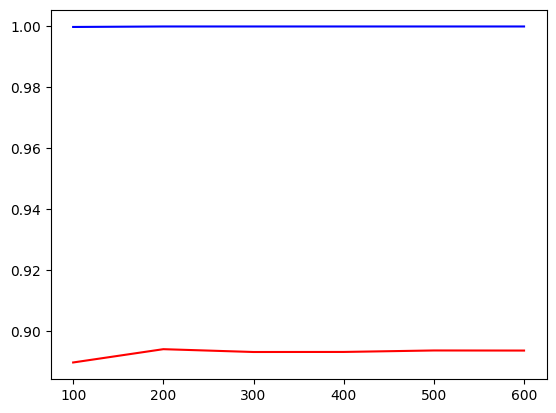

In [42]:
n_estimators_values = (100, 200, 300, 400, 500, 600)

train_score, test_score = [], []
for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=4, n_estimators=n_estimators)
    rf_clf.fit(X_train2d, y_train1d)
    predictions = rf_clf.predict(X_train2d)
    train_f1 = f1_score(y_train1d, predictions, average='weighted')
    train_score.append(train_f1)
    predictions = rf_clf.predict(X_test2d)
    test_f1 = f1_score(y_test_1d, predictions, average='weighted')
    test_score.append(test_f1)
plt.plot(n_estimators_values, train_score, c='b')
plt.plot(n_estimators_values, test_score, c='r')

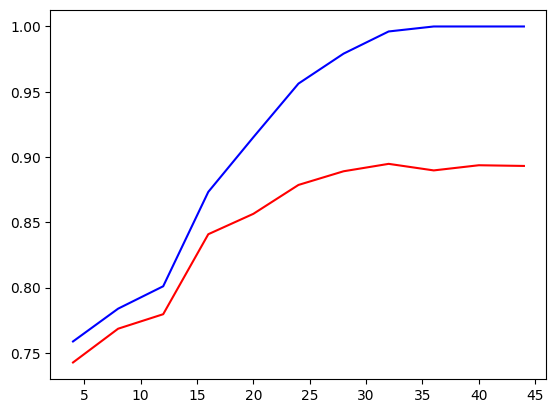

In [49]:
depth_values = ( 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44)

train_score, test_score = [], []
for depth in depth_values:
    rf_clf = RandomForestClassifier(max_depth=depth, min_samples_leaf=1, min_samples_split=4, n_estimators=200)
    rf_clf.fit(X_train2d, y_train1d)
    predictions = rf_clf.predict(X_train2d)
    train_f1 = f1_score(y_train1d, predictions, average='weighted')
    train_score.append(train_f1)
    predictions = rf_clf.predict(X_test2d)
    test_f1 = f1_score(y_test_1d, predictions, average='weighted')
    test_score.append(test_f1)
plt.plot(depth_values, train_score, c='b')
plt.plot(depth_values, test_score, c='r')

In [50]:
rf_clf = RandomForestClassifier(max_depth=32, min_samples_leaf=1, min_samples_split=4, n_estimators=200)
rf_clf.fit(X_train2d, y_train1d)
predictions = rf_clf.predict(X_test2d)
confusion_matrix(y_test_1d, predictions)

array([[1256,   14,    9],
       [ 106,  296,    0],
       [  87,    0,  332]], dtype=int64)

# Best model
XGBoost